# Training an Attention Model on Tensorflow Datasets
## Prerequisites

In [1]:
import json
import os
from typing import Any, Callable, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.core.display import display
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation
from official.modeling import tf_utils
from official.nlp.modeling.models.seq2seq_transformer import Seq2SeqTransformer, TransformerDecoder, TransformerEncoder
from official.nlp.modeling.ops import beam_search

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [4]:
#tf.debugging.set_log_device_placement(True)
GPUs = tf.config.list_physical_devices('GPU')
GPUs

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Configuration

In [5]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [6]:
if os.getcwd() == "/tf":
    os.chdir(os.path.join('workspace', 'notebooks'))

In [7]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [8]:
PROJECT = "PXD010000"

In [9]:
DUMP_PATH = os.path.join("/scratch/mirko.krause/dumps/", PROJECT)

In [10]:
print(f"dump path = {DUMP_PATH}")
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "*_mzmlid.parquet")
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

dump path = /scratch/mirko.krause/dumps/PXD010000


In [11]:
SEQ = 'peptide_sequence'

In [12]:
logger = log.create_logger(
    name='mmproteo_attention_model',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-07-17 18:21:42,956 - mmproteo_attention_model: Logging to file '/scratch/mirko.krause/dumps/PXD010000/mmproteo_attention_model.log' and to stderr


In [13]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 2354,
  'intensity_array': 2354,
  'peptide_sequence': 50},
 'idx_to_char': {'0': 'A',
  '1': 'C',
  '2': 'D',
  '3': 'E',
  '4': 'F',
  '5': 'G',
  '6': 'H',
  '7': 'I',
  '8': 'K',
  '9': 'L',
  '10': 'M',
  '11': 'M(Oxidation)',
  '12': 'N',
  '13': 'P',
  '14': 'Q',
  '15': 'R',
  '16': 'S',
  '17': 'T',
  '18': 'V',
  '19': 'W',
  '20': 'Y',
  '21': '_'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f8e5c0cf550>'},
 'split_value_columns': ['species', 'istrain'],
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence']}

In [14]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
idx_to_char[-1] = "[start]"
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [15]:
KEEP_CACHE = True

In [16]:
BATCH_SIZE = 8

In [17]:
TRAINING_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [18]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path=os.path.join(
        DATASET_DUMP_PATH,
        '*',  # filename
        '*',  # species
        '*'  # istrain
    ),
    path_position=-2,
    splits={
        TRAINING_TYPE: 0.4,
        TEST_TYPE: 0.5,
        EVAL_TYPE: 0.6
    },
    paths_dump_file=os.path.join(
        DATASET_DUMP_PATH,
        "dataset_file_paths.json"
    ),
    skip_existing=KEEP_CACHE,
    logger=logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 89
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/Biodiversity_P_polymyxa_TBS_aerobic_1_17July16_Samwise_16-04-10_mzmlid.parquet/Paenibacillus_polymyxa_ATCC842/Train
#Test = 27
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/Cj_media_MH_R3_23Feb15_Arwen_14-12-03_mzmlid.parquet/Campylobacter_jejuni/Train
#Eval = 38
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/M_alcali_copp_CH4_B3_T1_11_QE_23Mar18_Oak_18-01-07_mzmlid.parquet/Methylomicrobium_alcaliphilum/Train


2021-07-17 18:21:42,975 - mmproteo_attention_model: found file paths dump '/scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/dataset_file_paths.json'


### Loading corresponding TF datasets

In [19]:
element_spec = (
    tuple(tf.TensorSpec(shape=(PROCESSING_INFO['padding_lengths'][col],), dtype=tf.float32, name=col)
          for col in PROCESSING_INFO['training_data_columns']),
    tuple(tf.TensorSpec(shape=(PROCESSING_INFO['padding_lengths'][col],), dtype=tf.int8, name=col)
          for col in PROCESSING_INFO['target_data_columns'])
)
element_spec

((TensorSpec(shape=(2354,), dtype=tf.float32, name='mz_array'),
  TensorSpec(shape=(2354,), dtype=tf.float32, name='intensity_array')),
 (TensorSpec(shape=(50,), dtype=tf.int8, name='peptide_sequence'),))

**In the following step, Tensorflow starts allocating a GPU**

In [20]:
# initialize Tensorflow (might take several minutes (~5))
tf.data.Dataset.range(5)

<RangeDataset shapes: (), types: tf.int64>

In [21]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [22]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=False,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-07-17 18:27:52,375 - mmproteo_attention_model: DEBUG: preparing dataset 'Train' with 89 paths
2021-07-17 18:27:52,379 - mmproteo_attention_model: DEBUG: applied options to dataset 'Train'
2021-07-17 18:27:52,451 - mmproteo_attention_model: DEBUG: loaded dataset 'Train' interleaved
2021-07-17 18:27:52,452 - mmproteo_attention_model: DEBUG: shuffled dataset 'Train'
2021-07-17 18:27:52,453 - mmproteo_attention_model: DEBUG: batched dataset 'Train'
2021-07-17 18:27:52,453 - mmproteo_attention_model: DEBUG: skipped caching dataset 'Train'
2021-07-17 18:27:52,453 - mmproteo_attention_model: DEBUG: configured prefetching for dataset 'Train'
2021-07-17 18:27:52,454 - mmproteo_attention_model: DEBUG: skipped benchmarking dataset 'Train'
2021-07-17 18:27:52,454 - mmproteo_attention_model: prepared dataset 'Train'
2021-07-17 18:27:52,454 - mmproteo_attention_model: DEBUG: preparing dataset 'Test' with 27 paths
2021-07-17 18:27:52,455 - mmproteo_attention_model: DEBUG: applied options to data

{'Train': <PrefetchDataset shapes: (((8, 2354), (8, 2354)), ((8, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((8, 2354), (8, 2354)), ((8, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((8, 2354), (8, 2354)), ((8, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>}

In [23]:
original_datasets = datasets

In [24]:
def prefix_target_sequences_with_start_token(tensor: tf.Tensor, token: Any = char_to_idx["[start]"]) -> tf.Tensor:
    return tf.concat(
        values=[
            tf.broadcast_to(
                input=tf.constant(token, dtype=tensor.dtype),
                shape=(
                    tensor.shape[0],  # batch dimension
                    1
                )
            ),
            tensor
        ],
        axis=1
    )


def _dataset_mapper_for_transformer(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]):
    inputs = tf.stack(trainings, axis=-1)[:, :500, :]  # cut off too long spectra
    targets = prefix_target_sequences_with_start_token(targets[0])
    targets = tf.cast(
        x=targets,
        dtype=tf.int32,
    )

    return (
        {
            "inputs": inputs,
            "targets": targets[:, :-1],
        },
        targets[:, 1:]
    )


def prepare_dataset_for_transformer_training(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_transformer)

In [25]:
datasets = {
    t: prepare_dataset_for_transformer_training(dataset) for t, dataset in original_datasets.items()
}
datasets

{'Train': <MapDataset shapes: ({inputs: (8, 500, 2), targets: (8, 50)}, (8, 50)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Test': <MapDataset shapes: ({inputs: (8, 500, 2), targets: (8, 50)}, (8, 50)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Eval': <MapDataset shapes: ({inputs: (8, 500, 2), targets: (8, 50)}, (8, 50)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>}

In [26]:
print("original datasets:")
display(tfds.benchmark(original_datasets[TEST_TYPE]))

print()

print("mapped datasets:")
display(tfds.benchmark(datasets[TEST_TYPE]))

original datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4998.72 ex/sec (total: 74217 ex, 14.85 sec)
Examples/sec (First only) 0.45 ex/sec (total: 1 ex, 2.23 sec)
Examples/sec (First excluded) 5883.33 ex/sec (total: 74216 ex, 12.61 sec)


,duration,num_examples,avg
first+lasts,14.847190,74217,4998.723667
first,2.232567,1,0.447915
lasts,12.614623,74216,5883.330594



mapped datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3778.46 ex/sec (total: 74217 ex, 19.64 sec)
Examples/sec (First only) 0.47 ex/sec (total: 1 ex, 2.14 sec)
Examples/sec (First excluded) 4240.32 ex/sec (total: 74216 ex, 17.50 sec)


,duration,num_examples,avg
first+lasts,19.642144,74217,3778.457089
first,2.139696,1,0.467356
lasts,17.502448,74216,4240.321129


## Building the Tensorflow Model

In [27]:
# heavily based on:
# https://github.com/tensorflow/models/blob/061c58a3937953c79819fd4e8826af1570cb6024/official/nlp/transformer/transformer.py
# (29.06.2021)
class MyTransformer(Seq2SeqTransformer):
    def call(self, inputs):
        """Calculate target logits or inferred target sequences.
        Args:
          inputs: a dictionary of tensors.
            Feature `inputs`: int tensor with shape `[batch_size, input_length]`.
            Feature `targets` (optional): None or int tensor with shape
              `[batch_size, target_length]`.
        Returns:
          If targets is defined, then return logits for each word in the target
          sequence, which is a float tensor with shape
          `(batch_size, target_length, vocab_size)`. If target is `None`, then
          generate output sequence one token at a time and
          returns a dictionary {
              outputs: `(batch_size, decoded_length)`
              scores: `(batch_size, 1)`}
          Even when `float16` is used, the output tensor(s) are always `float32`.
        Raises:
          NotImplementedError: If try to use padded decode method on CPU/GPUs.
        """
        sources = inputs["inputs"]
        targets = inputs.get("targets", None)
        # Prepare inputs to the layer stack by adding positional encodings and
        # applying dropout.

        sources = self.source_embedding(sources)
        # Attention_mask generation.
        input_shape = tf_utils.get_shape_list(sources, expected_rank=3)
        batch_size = input_shape[0]
        input_length = input_shape[1]
        channel_count = input_shape[2]
        non_padding_sources = tf.not_equal(sources[:, :, 0], 0.0)
        non_padding_sources = tf.reshape(
            tensor=non_padding_sources,
            shape=[batch_size, 1, input_length]
        )
        attention_mask = tf.cast(
            x=non_padding_sources,
            dtype=sources.dtype
        )
        broadcast_ones = tf.ones(
            shape=[batch_size, input_length, 1],
            dtype=sources.dtype
        )
        attention_mask = broadcast_ones * attention_mask

        pos_encoding = self.position_embedding(sources)
        pos_encoding = tf.cast(pos_encoding, sources.dtype)
        encoder_inputs = sources + pos_encoding

        encoder_inputs = self.encoder_dropout(encoder_inputs)

        encoder_outputs = self.encoder_layer(
            encoder_inputs, attention_mask=attention_mask)

        if targets is None:
            if self._padded_decode:
                max_decode_length = self._decode_max_length
            else:
                max_decode_length = self._decode_max_length or (
                        tf.shape(encoder_outputs)[1] + self._extra_decode_length)
            symbols_to_logits_fn = self._get_symbols_to_logits_fn(max_decode_length)

            batch_size = tf.shape(encoder_outputs)[0]
            # Create initial set of IDs that will be passed to symbols_to_logits_fn.
            initial_ids = tf.zeros([batch_size], dtype=tf.int32)

            # Create cache storing decoder attention values for each layer.
            init_decode_length = (max_decode_length if self._padded_decode else 0)
            num_heads = self.decoder_layer.num_attention_heads
            dim_per_head = self._embedding_width // num_heads

            # Cache dtype needs to match beam_search dtype.
            # pylint: disable=g-complex-comprehension
            cache = {
                str(layer): {
                    "key":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype),
                    "value":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype)
                } for layer in range(self.decoder_layer.num_layers)
            }
            # pylint: enable=g-complex-comprehension

            # Add encoder output and attention bias to the cache.
            encoder_outputs = tf.cast(encoder_outputs, dtype=self.compute_dtype)
            attention_mask = tf.cast(
                tf.reshape(
                    tf.not_equal(sources, 0), [input_shape[0], 1, input_shape[1]]),
                dtype=self.compute_dtype)
            cache["encoder_outputs"] = encoder_outputs
            cache["encoder_decoder_attention_mask"] = attention_mask

            # Use beam search to find the top beam_size sequences and scores.
            decoded_ids, scores = beam_search.sequence_beam_search(
                symbols_to_logits_fn=symbols_to_logits_fn,
                initial_ids=initial_ids,
                initial_cache=cache,
                vocab_size=self._vocab_size,
                beam_size=self._beam_size,
                alpha=self._alpha,
                max_decode_length=max_decode_length,
                eos_id=self._eos_id,
                padded_decode=self._padded_decode,
                dtype=self.compute_dtype)

            # Get the top sequence for each batch element
            top_decoded_ids = decoded_ids[:, 0, 1:]
            top_scores = scores[:, 0]

            return {"outputs": top_decoded_ids, "scores": top_scores}

        decoder_inputs = self.embedding_lookup(targets)
        embedding_mask = tf.cast(tf.not_equal(targets, 0), decoder_inputs.dtype)
        decoder_inputs *= tf.expand_dims(embedding_mask, -1)
        # Shift targets to the right, and remove the last element
        decoder_inputs = tf.pad(decoder_inputs, [[0, 0], [1, 0], [0, 0]])[:, :-1, :]
        
        length = tf.shape(decoder_inputs)[1]
        pos_encoding = self.position_embedding(decoder_inputs)
        pos_encoding = tf.cast(pos_encoding, decoder_inputs.dtype)
        decoder_inputs += pos_encoding

        decoder_inputs = self.decoder_dropout(decoder_inputs)

        decoder_shape = tf_utils.get_shape_list(decoder_inputs, expected_rank=3)
        batch_size = decoder_shape[0]
        decoder_length = decoder_shape[1]

        self_attention_mask = tf.linalg.band_part(tf.ones([length, length]), -1, 0)
        self_attention_mask = tf.reshape(self_attention_mask, [1, length, length])
        self_attention_mask = tf.tile(self_attention_mask, [batch_size, 1, 1])

        attention_mask = tf.cast(
            tf.expand_dims(tf.not_equal(sources[:, :, 0], 0), axis=1), dtype=sources.dtype)
        attention_mask = tf.tile(attention_mask, [1, decoder_length, 1])

        outputs = self.decoder_layer(
            decoder_inputs,
            encoder_outputs,
            memory_mask=self_attention_mask,
            target_mask=attention_mask)
        
        logits = self._embedding_linear(self.embedding_lookup.embeddings, outputs)
        # Model outputs should be float32 to avoid numeric issues.
        # https://www.tensorflow.org/guide/mixed_precision#building_the_model
        logits = tf.cast(logits, tf.float32)
        return logits

In [28]:
TRANSFORMER_LAYERS = 8
ATTENTION_HEADS = 16
EMBEDDING_WIDTH = 512
LEARNING_RATE=10**-4

In [29]:
encoder_layer = TransformerEncoder(
    num_attention_heads=ATTENTION_HEADS,
    num_layers=TRANSFORMER_LAYERS,
)
decoder_layer = TransformerDecoder(
    num_attention_heads=ATTENTION_HEADS,
    num_layers=TRANSFORMER_LAYERS,
)

model = MyTransformer(
    vocab_size=len(idx_to_char),
    embedding_width=EMBEDDING_WIDTH,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    name=f"mmproteo_transformer_{utils.get_current_time_str()}",
    decode_max_length=PROCESSING_INFO['padding_lengths'][SEQ],
)
# create a new embedding layer that will be used in the overridden call method
model.source_embedding = tf.keras.layers.Conv1D(
    filters=EMBEDDING_WIDTH,
    kernel_size=1,
    activation=None,
    padding='same',
    name="source_embedding",
    use_bias=False,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        clipvalue=1.0,
        learning_rate=LEARNING_RATE,
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #masked_loss,
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(),
        tf.keras.metrics.SparseCategoricalCrossentropy()
    ]
)

In [30]:
model.predict(datasets[EVAL_TYPE].unbatch().batch(1).take(1))

array([[[-1.9293694 ,  0.19426323,  0.787314  , ..., -0.5484189 ,
          0.89359534, -1.4485174 ],
        [-1.9883614 ,  0.13863903,  0.6828624 , ..., -0.5114371 ,
          0.91365963, -1.4382948 ],
        [-1.8059468 , -0.36835906,  0.61709356, ..., -0.8088014 ,
          1.2649332 , -1.6012948 ],
        ...,
        [-1.6588717 , -0.2622395 ,  0.5649077 , ..., -1.213761  ,
          6.151469  , -2.3794758 ],
        [-1.6085639 , -0.24182785,  0.5679928 , ..., -1.2426987 ,
          6.0788584 , -2.3005118 ],
        [-1.562601  , -0.25035125,  0.55838585, ..., -1.2691    ,
          6.0054083 , -2.1804748 ]]], dtype=float32)

In [31]:
MODELS_PATH = os.path.join(DUMP_PATH, "models")
MODEL_PATH = os.path.join(MODELS_PATH, model.name)
MODEL_PATH

'/scratch/mirko.krause/dumps/PXD010000/models/mmproteo_transformer_20210717-182827'

In [32]:
utils.ensure_dir_exists(MODEL_PATH)

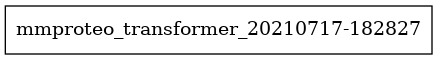

In [33]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True,
    expand_nested=True,
)

In [34]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")


    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_transformer_20210717-182827"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
on_device_embedding (OnDevic multiple                  11776     
_________________________________________________________________
transformer_encoder (Transfo multiple                  25203712  
_________________________________________________________________
transformer_decoder (Transfo multiple                  33600512  
_________________________________________________________________
relative_position_embedding  multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
source_embedding (Conv1D)    m

In [35]:
try:
    with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
        file.write(model.to_json())

    with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
        file.write(model.to_yaml())
except NotImplementedError as e:
    print("not implemented")

not implemented


## Training the Tensorflow Model

In [36]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [37]:
TENSORBOARD_LOG_DIR = os.path.join(MODEL_PATH, "tensorboard")
os.path.realpath(TENSORBOARD_LOG_DIR)

'/scratch/mirko.krause/dumps/PXD010000/models/mmproteo_transformer_20210717-182827/tensorboard'

In [38]:
training_dataset = datasets[TRAINING_TYPE].repeat()
validation_dataset = datasets[TEST_TYPE].repeat()

In [46]:
model.optimizer.clipvalue = None

In [47]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.01,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [44]:
model.optimizer.amsgrad = False

In [48]:
# to reset the learning_rate after it has been decreased by the reduce_lr callback
tf.keras.backend.set_value(model.optimizer.learning_rate, 10**-3)
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [49]:
model.fit(
    x=training_dataset,
    validation_data=validation_dataset,
    validation_steps=100,
    epochs=1000,
    steps_per_epoch=1000,
    callbacks=callbacks.create_callbacks(
        tensorboard=True,
        progressbar=False,
        reduce_lr=False,
        early_stopping=False,
        checkpoints=True,
        csv=False,
        base_path=MODEL_PATH,
    ),
    initial_epoch=206,
)

Epoch 207/1000
1000/1000 [==============================] - 262s 260ms/step - loss: 6.0314 - sparse_categorical_accuracy: 0.6516 - sparse_categorical_crossentropy: 6.0314 - val_loss: 6.0175 - val_sparse_categorical_accuracy: 0.6586 - val_sparse_categorical_crossentropy: 6.0175
Epoch 208/1000
1000/1000 [==============================] - 259s 259ms/step - loss: 6.1908 - sparse_categorical_accuracy: 0.6413 - sparse_categorical_crossentropy: 6.1908 - val_loss: 5.9422 - val_sparse_categorical_accuracy: 0.6634 - val_sparse_categorical_crossentropy: 5.9422
Epoch 209/1000
1000/1000 [==============================] - 259s 259ms/step - loss: 6.3155 - sparse_categorical_accuracy: 0.6321 - sparse_categorical_crossentropy: 6.3155 - val_loss: 5.8189 - val_sparse_categorical_accuracy: 0.6731 - val_sparse_categorical_crossentropy: 5.8189
Epoch 210/1000
 500/1000 [==============>...............] - ETA: 2:04 - loss: 6.3362 - sparse_categorical_accuracy: 0.6313 - sparse_categorical_crossentropy: 6.3362

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 6.3917 - sparse_categorical_accuracy: 0.6217 - sparse_categorical_crossentropy: 6.3917 - val_loss: 5.8096 - val_sparse_categorical_accuracy: 0.6738 - val_sparse_categorical_crossentropy: 5.8096
Epoch 222/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 6.4182 - sparse_categorical_accuracy: 0.6193 - sparse_categorical_crossentropy: 6.4182 - val_loss: 5.9526 - val_sparse_categorical_accuracy: 0.6614 - val_sparse_categorical_crossentropy: 5.9526
Epoch 223/1000
1000/1000 [==============================] - 259s 259ms/step - loss: 6.4189 - sparse_categorical_accuracy: 0.6194 - sparse_categorical_crossentropy: 6.4189 - val_loss: 5.8048 - val_sparse_categorical_accuracy: 0.6723 - val_sparse_categorical_crossentropy: 5.8048
Epoch 224/1000
 242/1000 [======>.......................] - ETA: 3:09 - loss: 6.3363 - sparse_categorical_accuracy: 0.6274 - sparse_categorical_crossentropy: 6.3363

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 6.1509 - sparse_categorical_accuracy: 0.6432 - sparse_categorical_crossentropy: 6.1509 - val_loss: 5.8833 - val_sparse_categorical_accuracy: 0.6659 - val_sparse_categorical_crossentropy: 5.8833
Epoch 236/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 6.0217 - sparse_categorical_accuracy: 0.6534 - sparse_categorical_crossentropy: 6.0217 - val_loss: 5.7935 - val_sparse_categorical_accuracy: 0.6726 - val_sparse_categorical_crossentropy: 5.7935
Epoch 237/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 6.0404 - sparse_categorical_accuracy: 0.6512 - sparse_categorical_crossentropy: 6.0404 - val_loss: 5.8837 - val_sparse_categorical_accuracy: 0.6681 - val_sparse_categorical_crossentropy: 5.8837
Epoch 238/1000
 701/1000 [====================>.........] - ETA: 1:14 - loss: 6.0242 - sparse_categorical_accuracy: 0.6528 - sparse_categorical_crossentropy: 6.0242

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 6.0906 - sparse_categorical_accuracy: 0.6499 - sparse_categorical_crossentropy: 6.0906 - val_loss: 5.9236 - val_sparse_categorical_accuracy: 0.6618 - val_sparse_categorical_crossentropy: 5.9236
Epoch 251/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 6.0079 - sparse_categorical_accuracy: 0.6566 - sparse_categorical_crossentropy: 6.0078 - val_loss: 5.7975 - val_sparse_categorical_accuracy: 0.6744 - val_sparse_categorical_crossentropy: 5.7975
Epoch 252/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 5.9002 - sparse_categorical_accuracy: 0.6637 - sparse_categorical_crossentropy: 5.9002 - val_loss: 5.7890 - val_sparse_categorical_accuracy: 0.6739 - val_sparse_categorical_crossentropy: 5.7890
Epoch 253/1000
 147/1000 [===>..........................] - ETA: 3:33 - loss: 5.9764 - sparse_categorical_accuracy: 0.6591 - sparse_categorical_crossentropy: 5.9764

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 6.0791 - sparse_categorical_accuracy: 0.6535 - sparse_categorical_crossentropy: 6.0791 - val_loss: 5.8600 - val_sparse_categorical_accuracy: 0.6694 - val_sparse_categorical_crossentropy: 5.8600
Epoch 264/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 5.9411 - sparse_categorical_accuracy: 0.6627 - sparse_categorical_crossentropy: 5.9411 - val_loss: 5.8999 - val_sparse_categorical_accuracy: 0.6653 - val_sparse_categorical_crossentropy: 5.8999
Epoch 265/1000
 817/1000 [=======================>......] - ETA: 45s - loss: 5.9156 - sparse_categorical_accuracy: 0.6640 - sparse_categorical_crossentropy: 5.9156

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 5.8526 - sparse_categorical_accuracy: 0.6683 - sparse_categorical_crossentropy: 5.8526 - val_loss: 5.8696 - val_sparse_categorical_accuracy: 0.6697 - val_sparse_categorical_crossentropy: 5.8696
Epoch 267/1000
 750/1000 [=====================>........] - ETA: 1:02 - loss: 5.8929 - sparse_categorical_accuracy: 0.6652 - sparse_categorical_crossentropy: 5.8929

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 6.0373 - sparse_categorical_accuracy: 0.6518 - sparse_categorical_crossentropy: 6.0373 - val_loss: 5.9393 - val_sparse_categorical_accuracy: 0.6618 - val_sparse_categorical_crossentropy: 5.9393
Epoch 279/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 5.9932 - sparse_categorical_accuracy: 0.6547 - sparse_categorical_crossentropy: 5.9932 - val_loss: 5.8954 - val_sparse_categorical_accuracy: 0.6682 - val_sparse_categorical_crossentropy: 5.8954
Epoch 280/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 5.9668 - sparse_categorical_accuracy: 0.6566 - sparse_categorical_crossentropy: 5.9668 - val_loss: 5.8547 - val_sparse_categorical_accuracy: 0.6690 - val_sparse_categorical_crossentropy: 5.8547
Epoch 281/1000
 370/1000 [==========>...................] - ETA: 2:37 - loss: 5.9831 - sparse_categorical_accuracy: 0.6538 - sparse_categorical_crossentropy: 5.9831

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 263s 263ms/step - loss: 6.0809 - sparse_categorical_accuracy: 0.6436 - sparse_categorical_crossentropy: 6.0809 - val_loss: 5.9067 - val_sparse_categorical_accuracy: 0.6647 - val_sparse_categorical_crossentropy: 5.9067
Epoch 293/1000
1000/1000 [==============================] - 263s 263ms/step - loss: 6.0413 - sparse_categorical_accuracy: 0.6467 - sparse_categorical_crossentropy: 6.0413 - val_loss: 5.7798 - val_sparse_categorical_accuracy: 0.6742 - val_sparse_categorical_crossentropy: 5.7798
Epoch 294/1000
1000/1000 [==============================] - 263s 263ms/step - loss: 6.0167 - sparse_categorical_accuracy: 0.6483 - sparse_categorical_crossentropy: 6.0167 - val_loss: 5.9857 - val_sparse_categorical_accuracy: 0.6581 - val_sparse_categorical_crossentropy: 5.9857
Epoch 295/1000
  69/1000 [=>............................] - ETA: 3:56 - loss: 6.0064 - sparse_categorical_accuracy: 0.6506 - sparse_categorical_crossentropy: 6.0064

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 6.1735 - sparse_categorical_accuracy: 0.6410 - sparse_categorical_crossentropy: 6.1735 - val_loss: 5.8946 - val_sparse_categorical_accuracy: 0.6643 - val_sparse_categorical_crossentropy: 5.8946
Epoch 307/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 6.0944 - sparse_categorical_accuracy: 0.6482 - sparse_categorical_crossentropy: 6.0944 - val_loss: 5.8970 - val_sparse_categorical_accuracy: 0.6665 - val_sparse_categorical_crossentropy: 5.8970
Epoch 308/1000
1000/1000 [==============================] - 261s 261ms/step - loss: 6.0515 - sparse_categorical_accuracy: 0.6510 - sparse_categorical_crossentropy: 6.0515 - val_loss: 5.8789 - val_sparse_categorical_accuracy: 0.6687 - val_sparse_categorical_crossentropy: 5.8789
Epoch 309/1000
 193/1000 [====>.........................] - ETA: 3:22 - loss: 6.1069 - sparse_categorical_accuracy: 0.6459 - sparse_categorical_crossentropy: 6.1069

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 889/1000 [=========================>....] - ETA: 28s - loss: 6.2417 - sparse_categorical_accuracy: 0.6415 - sparse_categorical_crossentropy: 6.2417

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 262s 262ms/step - loss: 6.1596 - sparse_categorical_accuracy: 0.6478 - sparse_categorical_crossentropy: 6.1596 - val_loss: 5.8330 - val_sparse_categorical_accuracy: 0.6705 - val_sparse_categorical_crossentropy: 5.8330
Epoch 322/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 6.0348 - sparse_categorical_accuracy: 0.6558 - sparse_categorical_crossentropy: 6.0348 - val_loss: 5.8640 - val_sparse_categorical_accuracy: 0.6695 - val_sparse_categorical_crossentropy: 5.8640
Epoch 323/1000
 227/1000 [=====>........................] - ETA: 3:13 - loss: 5.9881 - sparse_categorical_accuracy: 0.6602 - sparse_categorical_crossentropy: 5.9881

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 944/1000 [===========================>..] - ETA: 13s - loss: 6.1392 - sparse_categorical_accuracy: 0.6489 - sparse_categorical_crossentropy: 6.1393

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 6.0491 - sparse_categorical_accuracy: 0.6552 - sparse_categorical_crossentropy: 6.0492 - val_loss: 5.9434 - val_sparse_categorical_accuracy: 0.6633 - val_sparse_categorical_crossentropy: 5.9434
Epoch 336/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 5.9370 - sparse_categorical_accuracy: 0.6641 - sparse_categorical_crossentropy: 5.9370 - val_loss: 5.9478 - val_sparse_categorical_accuracy: 0.6627 - val_sparse_categorical_crossentropy: 5.9478
Epoch 337/1000
 348/1000 [=========>....................] - ETA: 2:42 - loss: 5.9704 - sparse_categorical_accuracy: 0.6627 - sparse_categorical_crossentropy: 5.9704

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 6.0405 - sparse_categorical_accuracy: 0.6561 - sparse_categorical_crossentropy: 6.0405 - val_loss: 5.7516 - val_sparse_categorical_accuracy: 0.6771 - val_sparse_categorical_crossentropy: 5.7516
Epoch 348/1000
   4/1000 [..............................] - ETA: 4:07 - loss: 5.5090 - sparse_categorical_accuracy: 0.6975 - sparse_categorical_crossentropy: 5.5090

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 6.0348 - sparse_categorical_accuracy: 0.6557 - sparse_categorical_crossentropy: 6.0348 - val_loss: 6.0224 - val_sparse_categorical_accuracy: 0.6578 - val_sparse_categorical_crossentropy: 6.0224
Epoch 350/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 5.9662 - sparse_categorical_accuracy: 0.6596 - sparse_categorical_crossentropy: 5.9662 - val_loss: 5.8003 - val_sparse_categorical_accuracy: 0.6725 - val_sparse_categorical_crossentropy: 5.8003
Epoch 351/1000
 305/1000 [========>.....................] - ETA: 2:54 - loss: 5.9334 - sparse_categorical_accuracy: 0.6609 - sparse_categorical_crossentropy: 5.9334

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 855/1000 [========================>.....] - ETA: 36s - loss: 6.2178 - sparse_categorical_accuracy: 0.6353 - sparse_categorical_crossentropy: 6.2178

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 259s 259ms/step - loss: 6.2626 - sparse_categorical_accuracy: 0.6322 - sparse_categorical_crossentropy: 6.2626 - val_loss: 5.8459 - val_sparse_categorical_accuracy: 0.6690 - val_sparse_categorical_crossentropy: 5.8459
Epoch 363/1000
1000/1000 [==============================] - 259s 259ms/step - loss: 6.3165 - sparse_categorical_accuracy: 0.6275 - sparse_categorical_crossentropy: 6.3165 - val_loss: 5.9825 - val_sparse_categorical_accuracy: 0.6624 - val_sparse_categorical_crossentropy: 5.9825
Epoch 364/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 6.1295 - sparse_categorical_accuracy: 0.6416 - sparse_categorical_crossentropy: 6.1295 - val_loss: 5.8499 - val_sparse_categorical_accuracy: 0.6714 - val_sparse_categorical_crossentropy: 5.8499
Epoch 365/1000
 154/1000 [===>..........................] - ETA: 3:31 - loss: 6.1078 - sparse_categorical_accuracy: 0.6432 - sparse_categorical_crossentropy: 6.1078

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 260s 260ms/step - loss: 6.2254 - sparse_categorical_accuracy: 0.6342 - sparse_categorical_crossentropy: 6.2254 - val_loss: 5.8588 - val_sparse_categorical_accuracy: 0.6695 - val_sparse_categorical_crossentropy: 5.8588
Epoch 375/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 6.2205 - sparse_categorical_accuracy: 0.6346 - sparse_categorical_crossentropy: 6.2205 - val_loss: 5.9950 - val_sparse_categorical_accuracy: 0.6580 - val_sparse_categorical_crossentropy: 5.9950
Epoch 376/1000
1000/1000 [==============================] - 260s 260ms/step - loss: 6.1477 - sparse_categorical_accuracy: 0.6404 - sparse_categorical_crossentropy: 6.1477 - val_loss: 5.9402 - val_sparse_categorical_accuracy: 0.6642 - val_sparse_categorical_crossentropy: 5.9402
Epoch 377/1000
 123/1000 [==>...........................] - ETA: 3:39 - loss: 6.0686 - sparse_categorical_accuracy: 0.6444 - sparse_categorical_crossentropy: 6.0686

KeyboardInterrupt: 

## Evaluating the Tensorflow Model

In [ ]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

In [ ]:
evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [ ]:
evaluator.evaluate_model(model)

In [ ]:
eval_df, (x_eval, y_eval, y_pred) = evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

In [ ]:
eval_df.predicted.map(print)
None

broken loss function?

In [ ]:
np.argmax(y_pred[0], axis=1)

In [ ]:
datasets[EVAL_TYPE].take(1)

In [ ]:
model.predict(datasets[EVAL_TYPE].unbatch().batch(1).take(1))

In [ ]:
y_pred.shape

In [ ]:
y_pred